# NLP with RNNs and Attention

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    !pip install -q -U tensorflow-addons
    !pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


## AI Challenge: Can we build a machine that can read and write natural language?

* A common approach for natural language tasks is to use recurrent neural networks

***Start simple***

* starting with a character RNN 
* trained to predict the next character in a sentence. 

***Generate long text***

* This will allow us to generate some original text
* In the process we will see how to build a Tensor‐Flow Dataset on a very long sequence

***Today's topics:***



* Stateless RNN (which learns on random portions of text at each iteration, without any information on the rest of the text)
* Stateful RNN (which preserves the hidden state between training iterations and continues reading where it left off, allowing it to learn longer patterns). 
* RNN to perform sentiment analysis (e.g., reading movie reviews and extracting the rater’s feeling about the movie)
* Encoder–Decoder architecture capable of performing neural machine translation (NMT)

* Attention mechanisms


## Deep Fake Shakespearean Text Using a Character RNN

***The ideas:***

* Train an RNN to predict the **next character** in a sentence. 
* This Char-RNN can then be used to generate novel text, **one character at a time**.

***The expected result:***

* Here is a small sample of the text generated by a Char-RNN model after it was trained on all of Shakespeare’s work:
```
PANDARUS:
Alas, I think he shall be come approached and the day
When little srain would be attain’d into being never fed,
And who is but a chain and subjects of his death,
I should not sleep.
```

## Creating the Training Dataset

* First, download all of Shakespeare’s work, using Keras’s handy get_file() function and downloading the data from Andrej Karpathy’ [Char-RNN project](https://github.com/karpathy/char-rnn):

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [4]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [5]:
shakespeare_text

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

* Then we must **encode every character as an integer**.

* We will use Keras’ Tokenizer class. First we need to fit a **tokenizer** to the text: **it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters** (it does not start at 0, so we can use that value for masking):

In [6]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

***Notes***

* We set **char_level=True** to get **character-level encoding rather than the default word-level encoding**. Note that this **tokenizer converts the text to lowercase by default** (but you can set lower=False if you do not want that)

* Now the tokenizer can encode a sentence (or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text

* More details about Keras Tokenizer: [Keras Tokenizer Tutorial with Examples for Beginners](https://machinelearningknowledge.ai/keras-tokenizer-tutorial-with-examples-for-fit_on_texts-texts_to_sequences-texts_to_matrix-sequences_to_matrix/)

In [7]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [8]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [9]:
tokenizer.texts_to_sequences(["abcdefghijklmnopqrstuvwxyz"])

[[5,
  22,
  19,
  13,
  2,
  20,
  21,
  7,
  6,
  33,
  25,
  12,
  15,
  10,
  4,
  23,
  34,
  9,
  8,
  3,
  14,
  26,
  17,
  35,
  16,
  36]]

In [10]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [11]:
max_id = len(tokenizer.word_index) # number of distinct characters
max_id

39

In [12]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

In [48]:
tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'i': 6,
 'h': 7,
 's': 8,
 'r': 9,
 'n': 10,
 '\n': 11,
 'l': 12,
 'd': 13,
 'u': 14,
 'm': 15,
 'y': 16,
 'w': 17,
 ',': 18,
 'c': 19,
 'f': 20,
 'g': 21,
 'b': 22,
 'p': 23,
 ':': 24,
 'k': 25,
 'v': 26,
 '.': 27,
 "'": 28,
 ';': 29,
 '?': 30,
 '!': 31,
 '-': 32,
 'j': 33,
 'q': 34,
 'x': 35,
 'z': 36,
 '3': 37,
 '&': 38,
 '$': 39}

* Let’s encode the full text so each character is represented by its ID (we subtract 1 to get IDs from 0 to 38, rather than from 1 to 39):

In [13]:
import numpy as np
np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

array([[19,  5,  8, ..., 20, 26, 10]])

In [14]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
encoded

array([19,  5,  8, ..., 20, 26, 10])

Before we continue, we need to split the dataset into a training set, a validation set, and a test set. We **can’t just shuffle all the characters in the text,** so how do you split a sequential dataset?

### How to prepare the data: Splitting a sequence into batches of shuffled windows

* split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.)
* then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`)
* then create batches of 3 such input/target pairs:

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))

# The window() method creates a dataset that contains windows,
#   each of which is also represented as a dataset. It’s a nested dataset,
#   similar to a list of lists.
# drop_remainder=True
#   To ensure that all windows are exactly n_steps characters long
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)

# we cannot use a nested dataset directly for training,
# as our model will expect tensors as input, not datasets.
# So, we must call the flat_map() method: it converts a nested dataset into
# a flat dataset (one that does not contain datasets).
#   If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}},
#      you get back the flat dataset {1, 2, 3, 4, 5, 6}.
#   if you pass the function lambda ds: ds.batch(2) to flat_map(),
#      then it will transform the nested dataset {{1, 2}, {3, 4, 5,6}} into the
#      flat dataset {[1, 2], [3, 4], [5, 6]}: it’s a dataset of tensors of size 2
#   Notice that we call batch(n_steps) on each window: since all windows have
#   exactly that length, we will get a single tensor for each of them.

dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## The hardest part - Loading the Data and Preparing the Dataset

***Some tips of splitting data***

* Take the first 90% of the text for the training set, then the next 5% for the validation set, and the final 5% for the test set

* It would also be a good idea to **leave a gap between these sets** to **avoid** the risk of a **paragraph overlapping** over two sets

* When dealing with time series, you would in general **split across time,:** for example, you might take the years **2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.** However, in some cases you may be able to split along other dimensions, which will give you a longer time period to train on

* So, it is often safer to split across time—but this implicitly **assumes that the patterns the RNN can learn in the past** (in the training set) **will still exist in the future.** In other words, we assume that the time series is **stationary**

* For many time series this assumption is reasonable **(e.g., chemical reactions should be fine, since the laws of chemistry don’t change every day),** but **for many others it is not (e.g., financial markets are notoriously not stationary since patterns disappear as soon as traders spot them and start exploiting them)**

* To **make sure** the time series is indeed sufficiently **stationary,** you can **plot the model’s errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough,** and you might be **better off training the model on a shorter time span.**

Now back to Shakespeare! Let’s take the first 90% of the text for the training set (keeping the rest for the validation set and the test set), and create a tf.data.Dataset that will return each character one by one from this set:

In [16]:
dataset_size = tokenizer.document_count # total number of characters
dataset_size

1115394

In [17]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100 # 90% for training # 1003854
encoded[:train_size]

array([19,  5,  8, ...,  1,  8,  1])

* create a tensorflow dataset from a np array
* The from_tensor_slices() function takes a tensor and creates a tf.data.Dataset
whose elements are all the slices of X (along the first dimension)

In [21]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size]) 
dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

**Note**: in previous versions of this code, we used `dataset.repeat()` now to make the dataset "infinite", and later in the notebook we set the `steps_per_epoch` argument when calling the `model.fit()` method. This was needed to work around some TensorFlow bugs. However, since these bugs have now been fixed, we can simplify the code: no need for `dataset.repeat()` or `steps_per_epoch` anymore.

## Chopping the Sequential Dataset into Multiple Windows

* The training set now consists of a single sequence of **over a million characters,** so we **can’t just train the neural network directly** on it: **the RNN would be equivalent to a deep net with over a million layers,** and we would have a single (very long) instance to train it

* Instead, we will use the dataset’s **window() method** to **convert** this long sequence of characters **into many smaller windows of text**

* **Every instance** in the dataset will be a **fairly short substring of the whole text,** and the **RNN will be unrolled only over the length of these substrings.** This is called **truncated backpropagation through time**

Let's call the window() method to create a dataset of short text windows:

In [22]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)
dataset

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(), dtype=tf.int32, name=None), TensorShape([]))>

* Check the top 10

In [34]:
for k, i in enumerate(dataset):
    print(i)
    if k > 10:
        break

<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
<_VariantDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>


In [38]:
for k, window in enumerate(dataset):
    print([item.numpy() for item in window])
    print("size=", len([item.numpy() for item in window]))
    if k>10: break

[19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0]
size= 101
[5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0, 4]
size= 101
[8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 1

***Notes***

* By **default,** the **window()** method **creates nonoverlapping windows,** but **to get the largest possible training set we use shift=1** so the **first window contains characters 0 to 100. the second contains characters 1 to 101,** and so on

* To **ensure that all windows are exactly 101 characters** long (which will allow us to create batches without having to do any padding), we set **drop_remainder=True** (otherwise the last 100 windows will contain 100 characters, 99 characters, and so on down to 1 character)

* The **window() method creates a dataset that contains windows, each of which is also represented as a dataset.** It’s a **nested dataset,** analogous to a list of lists

* This is useful when you want to transform each window by calling its dataset methods (e.g., to shuffle them or batch them). However, we **cannot use a nested dataset directly for training,** as our model will **expect tensors as input,** not datasets

* So, we must call the **flat_map() method:** it **converts a nested dataset into a flat dataset** (one that does not contain datasets). For example, suppose {1, 2, 3} represents a dataset containing the sequence of tensors 1, 2, and 3. **If you flatten the nested dataset {{1, 2}, {3, 4, 5, 6}}, you get back the flat dataset {1, 2, 3, 4, 5, 6}**

* Moreover, the **flat_map() method takes a function as an argument, which allows you to transform each dataset in the nested dataset before flattening.** For example, if you pass the function **lambda ds: ds.batch(2) to flat_map(),** then it will transform the nested dataset {{1, 2}, {3, 4, 5, 6}} into the flat dataset **{[1, 2], [3, 4], [5, 6]}:** it’s a dataset of tensors of size 2 

With that in mind, we are ready to flatten our dataset:

In [39]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [40]:
dataset

<FlatMapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int32, name=None)>

In [41]:
for k, window in enumerate(dataset):
    print([item.numpy() for item in window])
    print("size=", len([item.numpy() for item in window]))
    if k>10: break

[19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0]
size= 101
[5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 15, 3, 13, 0, 4]
size= 101
[8, 7, 2, 0, 18, 5, 2, 5, 35, 1, 9, 23, 10, 21, 1, 19, 3, 8, 1, 0, 16, 1, 0, 22, 8, 3, 18, 1, 1, 12, 0, 4, 9, 15, 0, 19, 13, 8, 2, 6, 1, 8, 17, 0, 6, 1, 4, 8, 0, 14, 1, 0, 7, 22, 1, 4, 24, 26, 10, 10, 4, 11, 11, 23, 10, 7, 22, 1, 4, 24, 17, 0, 7, 22, 1, 4, 24, 26, 10, 10, 19, 5, 8, 7, 2, 0, 1

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

* Notice that we call batch(window_length) on each window: since all windows have exactly that length, we will get a single tensor for each of them. **Now the dataset contains consecutive windows of 101 characters each**

* Since **Gradient Descent** works best when the instances in the **training set are independent and identically distributed**, we need to shuffle these windows. 
* ```shuffle(buffer_size, seed)``` will create a new dataset
that will start by filling up a buffer with the first items of the source dataset. Then,
whenever it is asked for an item, it will pull one out randomly from the buffer and
replace it with a fresh one from the source dataset, until it has iterated entirely
through the source dataset.
* Then we can batch the windows and separate the inputs (the first 100 characters) from the target (the last character):

In [43]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
                                       # X_inputs,        Y_target

### The dataset preparation steps discussed so far (showing windows of length 11 rather than 101, and a batch size of 3 instead of 32)

<p align='center'>
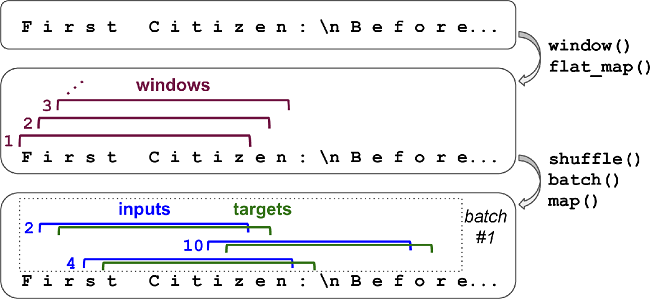
</p>

* categorical input features should generally be encoded, usually as one-hot vectors or as embeddings. Here, we will encode each character using a one-hot vector because there are fairly few distinct characters (only 39)

In [44]:
# max_id = len(tokenizer.word_index) # number of distinct characters
# max_id # 39
# X_batch is the text characters' indices-1(means the index is start from 0)
# [encoded] = np.array( tokenizer.texts_to_sequences([shakespeare_text]) )-1
# so the actual max_id=38

dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

* Finally, we just need to add prefetching:

In [45]:
dataset = dataset.prefetch(1)

In [47]:
for k, window in enumerate(dataset):
    print([item.numpy() for item in window])
    print("size=", len([item.numpy() for item in window]))
    if k>10: break

[array([[[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0

In [46]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape) #  batch size 32, distinct characters 39, window size 100

(32, 100, 39) (32, 100)


## Creating and Training the Char-RNN Model

**Warning**: the following code may take up to <font color='red'>24 hours</font> to run, depending on your hardware. If you use a GPU, it may take just 1 or 2 hours, or less.

**Note**: the `GRU` class will only use the GPU (if you have one) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` and `reset_after`. This is why I commented out `recurrent_dropout=0.2` .


### GRU cell
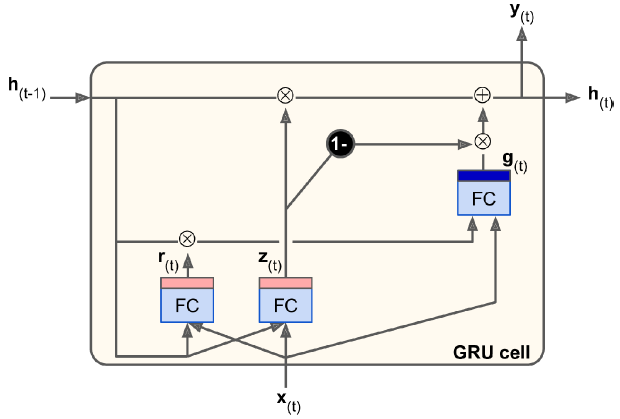

### GRU computations

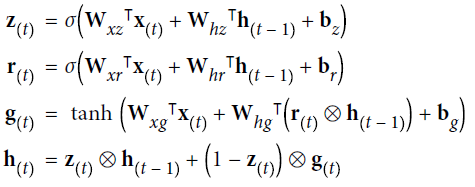

***The ideas to build the model***

* To **predict the next character based on the previous 100 characters,** we can use an **RNN with 2 GRU layers of 128 units** each and **20% dropout** on both the **inputs (dropout)** and the **hidden states (recurrent_dropout)**

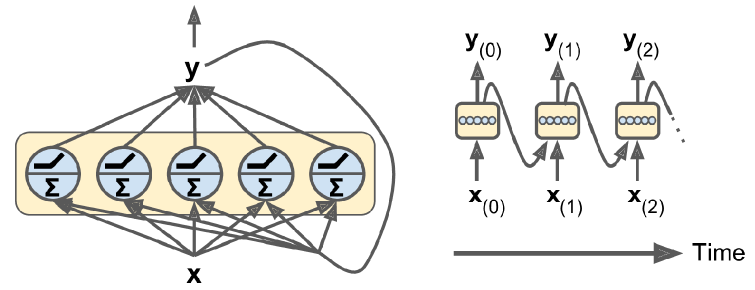

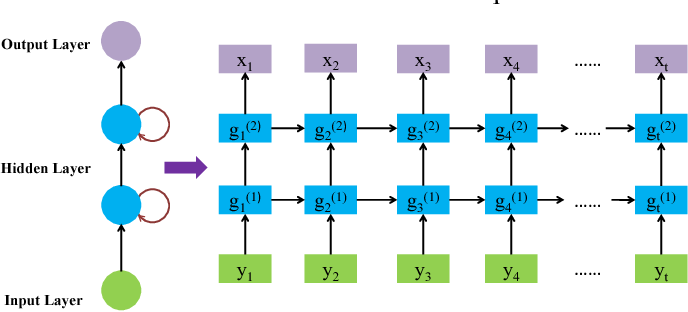

* The output layer is a time distributed Dense layer. This time this **layer must have 39 units** (max_id) **because there are 39 distinct characters in the text,** and we want to **output a probability for each possible character** (at each time step)

* The **output probabilities should sum up to 1** at each time step, so we apply the **softmax activation function** to the outputs of the Dense layer

* To turn the model into a sequence-to-sequence model, we must set return_sequences=True in all recurrent layers (even the last one), and we must apply the output Dense layer at every time step. **Keras offers a ```TimeDistributed``` layer for this very purpose: it wraps any layer (e.g., a Dense layer) and applies it at every time step of its input sequence.**

* We can then compile this model, using the **'sparse_categorical_crossentropy' loss and an Adam optimizer.** Finally, we are ready to train the model for several epochs

Finally, we are ready to train the model for several epochs (this may take many hours, depending on your hardware):

In [18]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.GRU(128, return_sequences=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=10)

#history = model.fit(dataset, epochs=2) # 10 epochs originally, changed to 2 epochs for less training time since each epoch takes ~ 2 hours
#model.save('CHAR_RNN.h5')

Epoch 1/10
31368/31368 [==============================] - 7150s 228ms/step - loss: 1.4671
Epoch 2/10
31368/31368 [==============================] - 7094s 226ms/step - loss: 1.3614
Epoch 3/10
31368/31368 [==============================] - 7063s 225ms/step - loss: 1.3404
Epoch 4/10
31368/31368 [==============================] - 7039s 224ms/step - loss: 1.3311
Epoch 5/10
31368/31368 [==============================] - 7056s 225ms/step - loss: 1.3256
Epoch 6/10
31368/31368 [==============================] - 7049s 225ms/step - loss: 1.3209
Epoch 7/10
31368/31368 [==============================] - 7068s 225ms/step - loss: 1.3166
Epoch 8/10
31368/31368 [==============================] - 7030s 224ms/step - loss: 1.3138
Epoch 9/10
31368/31368 [==============================] - 7061s 225ms/step - loss: 1.3120
Epoch 10/10
31368/31368 [==============================] - 7177s 229ms/step - loss: 1.3105


***Or, we can use the trained model directly***

In [51]:
model = keras.models.load_model('CHAR_RNN.h5')

## Using the Char-RNN Model to Generate Text

* Now we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let’s create a little function for this:

In [19]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Warning**: the `predict_classes()` method is deprecated. Instead, we must use `np.argmax(model(X_new), axis=-1)`.

* Now let’s use the model to predict the next letter in some text:

In [20]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'u'

#### Success! The model guessed right. Now let’s use this model to generate new text



In [21]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 2, 1,
        0, 1, 2, 1, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 2]])

## Generating Fake Shakespearean Text

* To generate new text using the Char-RNN model, we could **feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next letter,** and so on

* But in practice this often **leads to the same words being repeated over and over again.** Instead, we can **pick the next character randomly,** with a **probability equal to the estimated probability,** using TensorFlow’s tf.random.categorical() function. This will generate **more diverse** and interesting text

* The **categorical() function samples random class indices, given the class log probabilities (logits).** To have **more control over the diversity** of the generated text, we can **divide the logits by a number called the temperature,** which we can tweak as we wish: a **temperature close to 0 will favor the high-probability characters,** while a **very high temperature will give all characters an equal probability**

The following next_char() function uses this approach to pick the next character to add to the input text:

In [22]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [23]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

* Next, we can write a small function that will **repeatedly call next_char()** to get the next character and append it to the given text:

In [24]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

* We are now ready to generate some text! Let's try with different temperatures:

In [25]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the belly the charges of the other words
and belly 


In [26]:
print(complete_text("t", temperature=1))

thing! they know't.

biondello:
for you are the own


In [27]:
print(complete_text("t", temperature=2))

th no cyty
use ffor was firive this toighingaber; b


Apparently our Shakespeare model works best at a temperature close to 1 

***Some ideas to improve the model:***

To **generate more convincing text,** you could try using **more GRU layers** and more neurons per layer, **train for longer,** and add some **regularization** (for example, you could set recurrent_dropout=0.3 in the GRU layers)

Moreover, the model is currently incapable of learning patterns longer than n_steps, which is just 100 characters. You could try **making this window larger, but it will also make training harder,** and even **LSTM and GRU cells cannot handle very long sequences.** Alternatively, you could use a stateful RNN

## Stateless RNN vs. Stateful RNN

***stateless RNN:***
* starts with a hidden state full of zeros
* then it **updates this state at each time step**, and after the last time step, it **throws it away**

***Stateful RNN:***

* **preserve this final state** after processing one training batch and use it **as the initial state for the next training batch**
* the model can learn **long-term patterns** despite only backpropagating through short sequences.

***Notes:***

*  **a stateful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in the previous batch left off**
* the **first thing** we need to **do to build a stateful RNN** is to **use sequential and nonoverlapping input sequences (rather than the shuffled and overlapping sequences** we used to train stateless RNNs)
* When creating the Dataset, we must therefore use shift=n_steps (instead of shift=1) when calling the window() method. Moreover, we must obviously not call the shuffle() method
* The simplest solution to this problem is to just use **“batches” containing a single window**

In [28]:
tf.random.set_seed(42)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

### summarizes the first steps

    Preparing a dataset of consecutive sequence fragments for a stateful RNN

<p align='center'>
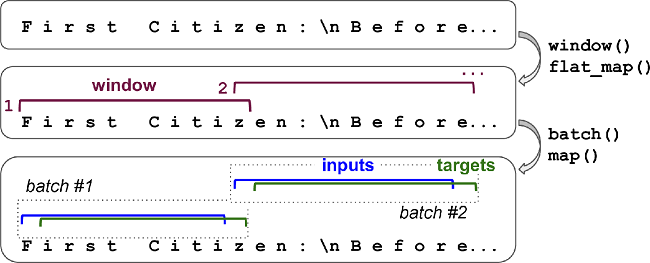
</p>


***Batching***

Batching is harder, but it is not impossible. Some ideas:

* we could **chop Shakespeare’s text into 32 texts of equal length,** create one dataset of consecutive input sequences for each of them
* then use tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows)) to create proper consecutive batches, where the **$n^{th}$ input sequence** in a batch **starts off exactly where the $n^{th}$ input sequence ended in the previous batch**

In [30]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

### Create the stateful RNN

* set **stateful=True** when creating every recurrent layer
* the **stateful RNN needs to know the batch size** (since it will preserve a state for each input sequence in the batch), so we must set the batch_input_shape argument in the first layer


**Note**: once again, I commented out `recurrent_dropout=0.2` (compared to the book) so you can get GPU acceleration (if you have one).

In [31]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     #dropout=0.2, recurrent_dropout=0.2),
                     dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

* At the **end of each epoch**, we use a small callback to **reset the states before we go back to the beginning of the text**.

In [32]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

* compile and fit the model
* Use epochs=50, because each epoch is much shorter than earlier, and there is only one instance per batch

In [33]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 62s 198ms/step - loss: 2.6189
Epoch 2/50
313/313 [==============================] - 58s 187ms/step - loss: 2.2091
Epoch 3/50
313/313 [==============================] - 56s 178ms/step - loss: 2.0775
Epoch 4/50
313/313 [==============================] - 56s 179ms/step - loss: 2.4689
Epoch 5/50
313/313 [==============================] - 56s 179ms/step - loss: 2.3274
Epoch 6/50
313/313 [==============================] - 57s 183ms/step - loss: 2.1412
Epoch 7/50
313/313 [==============================] - 57s 183ms/step - loss: 2.0748
Epoch 8/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9850
Epoch 9/50
313/313 [==============================] - 56s 179ms/step - loss: 1.9465
Epoch 10/50
313/313 [==============================] - 56s 179ms/step - loss: 1.8995
Epoch 11/50
313/313 [==============================] - 57s 182ms/step - loss: 1.8576
Epoch 12/50
313/313 [==============================] - 56s 179ms/step - lo

***If the training is too slow, you can get the trained model directly***

In [ ]:
model = keras.models.load_model('CHAR_RNN_STATEFUL.h5')

### The restriction

* it will only be possible to use it to make predictions for **batches of the same size as were used during training**. 
* To avoid this restriction, create an identical stateless model, and copy the stateful model’s weights to this model.

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [34]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [35]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [36]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [37]:
tf.random.set_seed(42)

print(complete_text("t"))

tor:
in the negver up how it thou like him;
when it


#  Character-level model vs. word-level model, Sentiment Analysis

In [38]:
tf.random.set_seed(42)

* If MNIST is the “hello world” of computer vision, then the **IMDb reviews dataset is the “hello world” of natural language processing:** it consists of 50,000 movie reviews in English (25,000 for training, 25,000 for testing) extracted from the famous Internet Movie Database, along with a simple binary target for each review **indicating whether it is negative (0) or positive (1)**

You can load the IMDB dataset easily:

In [39]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


In [40]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

* X_train consists of a list of reviews, each of which is represented as a NumPy array of integers, where **each integer represents a word.**
* **All punctuation was removed, and then words were converted to lowercase, split by spaces, and finally indexed by frequency** (so low integers correspond to frequent words). 
* The integers **0, 1, and 2 are special**: they represent the padding token, the start-of-sequence (SSS) token, and unknown words, respectively. 


Decode to get the review:

In [41]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

***Notes***

* When encoding words, it filters out a lot of characters, including most punctuation, line breaks, and tabs
* spaces to identify word boundaries
* tokenize and detokenize text at the subword level in a language-independent way
* even if your model encounters a word it has never seen before, it can still reasonably guess what it means

**load the original IMDb reviews, as text (byte strings), using TensorFlow Datasets**

In [42]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-train.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-test.tfrecord


Shuffling and writing examples to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteK5RNB1/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /home/aurelien_geron_kiwisoft_io/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [43]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [44]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [45]:
train_size, test_size

(25000, 25000)

In [46]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



### Preprocessing

* It starts by **truncating** the reviews, **keeping only the first 300 characters** of each: this will speed up training, and it won’t impact performance too much because you can generally tell whether a review is positive or not in the first sentence or two

* Then it uses regular expressions to **replace `<br/>` tags with spaces,** and to **replace any characters other than letters and quotes with spaces**

    For example ```Well, I can't<br/>``` will become ```Well I can't```
    

* Finally, the preprocess() function **splits the reviews by the spaces,** which returns a ragged tensor, and it converts this ragged tensor to a dense tensor, padding all reviews with the **padding token '<pad>'** so that they all have the **same length**



In [47]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [48]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

* Next, we need to **construct the vocabulary.** This requires **going through the whole training set once,** applying our preprocess() function, and **using a Counter to count the number of occurrences of each word:**

In [49]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

* Let’s look at the three most common words

In [50]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [51]:
len(vocabulary)

53893

* We probably don’t need our model to know all the words in the dictionary to get good performance, though, so let’s **truncate** the vocabulary, **keeping only the 10,000 most common words:**

In [52]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [53]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


* Now we need to add a preprocessing step to replace each word with its ID (i.e., its index in the vocabulary). We will **create a lookup table** for this, **using 1,000 out-of-vocabulary (oov) buckets:**

In [54]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

* We can then use this table to look up the IDs of a few words:

In [55]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

* Note that the words **“this,” “movie,” and “was” were found in the table,** so their **IDs are lower than 10,000,** while the word **“faaaaaantastic” was not found,** so it was **mapped to one of the oov buckets,** with an **ID greater than or equal to 10,000**

In [56]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [57]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


### Word Embedding

* an efficient way of representing words into mathematical concepts

Two options:

* assign a unique integer to a unique word

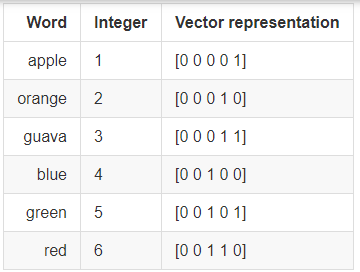

or 

* one-hot encoding

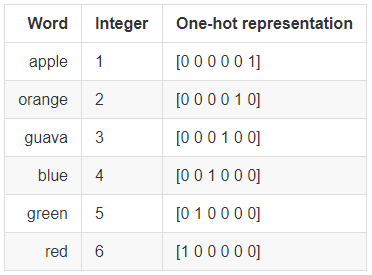

***Drawbacks***

* no relation captured between words
    * We want the mathematical structure of word representation to hold meaning rather than simple integers representing words. 
    * It would be good if there was some way we can capture similar words together.
    
*  the sparse representation of words need big vectors as our vocabulary size grows so it is not efficient

***Word Embedding***

*  a mathematical structure to represent words more efficiently
* use dense representation to capture words relation
* Word embeddings of similar words tend to be close, and some axes seem to encode meaningful concepts


***Example: Word vectors in 2D (similar words are closer to each other)***

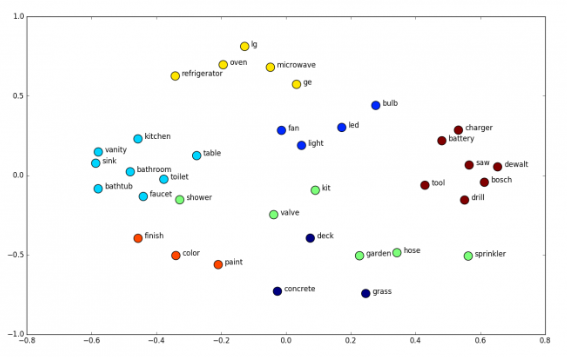



***How to find word vector for a specified word***

* **word embedding matrix**: imagine a matrix having the same number of rows as number of unique words in our vocabulary and each row representing the word vector. 

* This matrix has **rows as the number of unique words** in the vocabulary and **number of columns as the hyper parameter/user-specified**

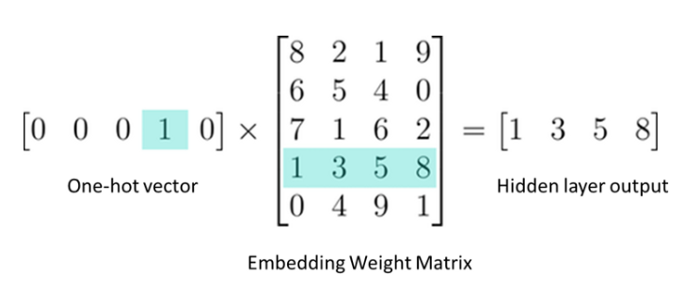

* We can keep such a **layer at the beginning of the network and train the Embedding layer** with the rest of the network for our custom data set.

* Keras provides us with such an **Embedding layer** to train, we will use it for our network’s first layer.

### Now we are ready to create the model and train it:

* The first layer is an **Embedding layer,** which will convert word IDs into embeddings

* **The embedding matrix needs to have one row per word ID (vocab_size + num_oov_buckets) and one column per embedding dimension** (this example uses 128 dimensions, but this is a hyperparameter you could tune)

* Whereas the **inputs** of the model will be **2D tensors of shape [batch size, time steps],** the **output** of the Embedding layer will be a **3D tensor of shape [batch size, time steps, embedding size]**

* "mask" tells the model to ignore the padding tokens, so that it can focus on the data that actually matters

* The rest of the model is fairly straightforward: it is composed of two GRU layers, with the second one returning only the output of the last time step. The output layer is just a **single neuron** using the **sigmoid activation function** to **output the estimated probability that the review expresses a positive sentiment** regarding the movie. We then compile the model quite simply, and we fit it on the dataset we prepared earlier, for a few epochs.

In [58]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, 
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 118s 152ms/step - loss: 0.5305 - accuracy: 0.7282
Epoch 2/5
782/782 [==============================] - 113s 145ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
782/782 [==============================] - 113s 145ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
782/782 [==============================] - 114s 146ms/step - loss: 0.1341 - accuracy: 0.9535
Epoch 5/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1011 - accuracy: 0.9624


Or using manual masking:

In [59]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 118s 152ms/step - loss: 0.5425 - accuracy: 0.7155
Epoch 2/5
782/782 [==============================] - 112s 143ms/step - loss: 0.3479 - accuracy: 0.8558
Epoch 3/5
782/782 [==============================] - 112s 144ms/step - loss: 0.1761 - accuracy: 0.9388
Epoch 4/5
782/782 [==============================] - 115s 147ms/step - loss: 0.1281 - accuracy: 0.9531
Epoch 5/5
782/782 [==============================] - 116s 148ms/step - loss: 0.1088 - accuracy: 0.9603


## Reusing Pretrained Embeddings

* The [TensorFlow Hub](https://tfhub.dev/) project makes it easy to reuse pretrained model components in your own models. These model components are called modules

* Simply browse the TF Hub repository, find the one you need, and copy the code example into your project, and the module will be automatically downloaded, along with its pretrained weights, and included in your model

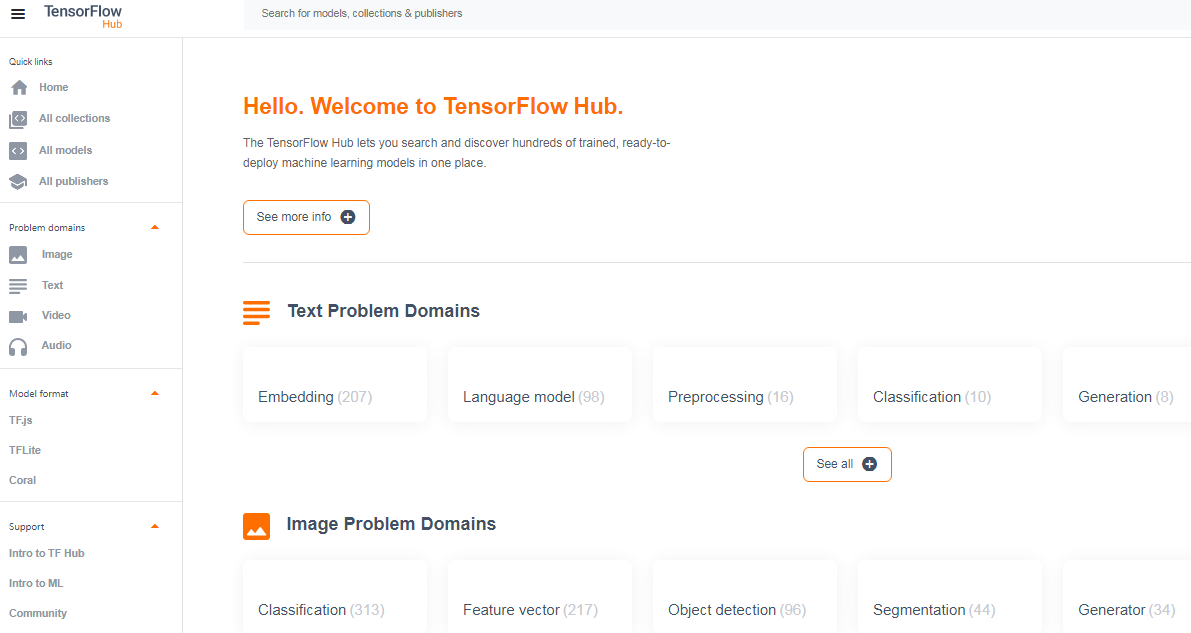

* For example, let’s use the **nnlm-en-dim50 sentence embedding module,** version 1, in our sentiment analysis model:

In [60]:
tf.random.set_seed(42)

In [61]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [62]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [63]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


***Notes***

* The **hub.KerasLayer layer downloads the module** from the given URL

* This particular module is a **sentence encoder:** it takes strings as input and **encodes** each one as a **single vector** (in this case, a 50-dimensional vector)

* Internally, it parses the string (splitting words on spaces) and embeds each word using an embedding matrix that was pretrained on a huge corpus: the Google News 7B corpus (**seven billion words** long!). Then it **computes the mean of all the word embeddings,** and the result is the **sentence embedding**

* We can then add two simple Dense layers to create a good sentiment analysis model. **By default, a hub.KerasLayer is not trainable,** but you can set **trainable=True** when creating it to change that so that you can fine-tune it for your task

Next, we can just load the IMDb reviews dataset—no need to preprocess it (except for batching and prefetching)—and directly train the model:

In [64]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].batch(batch_size).prefetch(1)
history = model.fit(train_set, epochs=5)

Epoch 1/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5129 - accuracy: 0.7495
Epoch 3/5
782/782 [==============================] - 129s 165ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5047 - accuracy: 0.7533
Epoch 5/5
782/782 [==============================] - 128s 164ms/step - loss: 0.5015 - accuracy: 0.7560


***Notes***

* Note that the last part of the TF Hub module URL specified that we wanted version 1 of the model. This versioning ensures that if a new model version is released, it will not break our model. Conveniently, if you just enter this URL in a web browser, you will get the documentation for this module

* **By default, TF Hub will cache the downloaded files into the local system’s temporary directory.** You may prefer to download them into a more permanent directory to avoid having to download them again after every system cleanup

* To do that, set the TFHUB_CACHE_DIR environment variable to the directory of your choice (e.g., **os.environ["TFHUB_CACHE_DIR"] = "./my_tfhub_cache")**



# Automatic Translation

* **neural machine translation (NMT)** 
* first using a pure **Encoder–Decoder model** 
* then improving it with **attention mechanisms** 


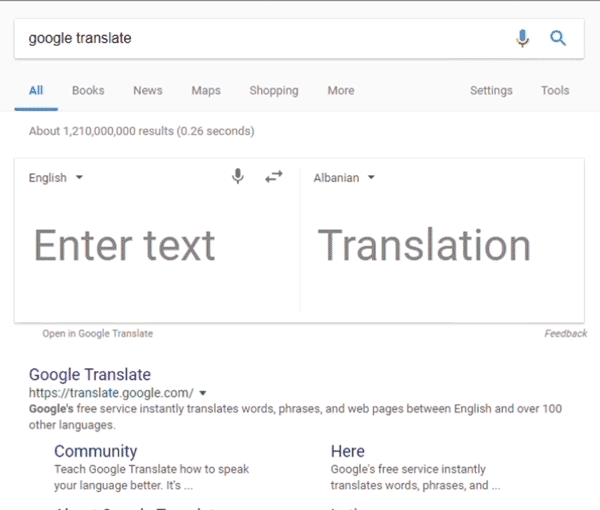

### An Encoder–Decoder Network for Neural Machine Translation

* a simple [neural machine translation model](https://arxiv.org/abs/1409.3215) that will translate English sentences to French

* In short, the **English sentences are fed to the encoder,** and the **decoder outputs the French translations.** Note that the **French translations are also used as inputs to the decoder, but shifted back by one step**

* In other words, the decoder is given as input the word that it should have output at the previous step (regardless of what it actually output)

* For the very **first word,** it is given the **start-of-sequence (SOS) token.** The **decoder** is expected to **end the sentence with an end-of-sequence (EOS) token**

* Note that the **English sentences are reversed before they are fed to the encoder.** For example, “I drink milk” is reversed to “milk drink I.” This ensures that the beginning of the English sentence will be fed last to the encoder, which is useful because that’s generally the first thing that the decoder needs to translate

* Each word is initially represented by its ID (e.g., 288 for the word “milk”) Next, an layer returns the word embedding. These word embedding embeddings are what is actually fed to the encoder and the decoder

**A simple machine translation model**

<p align='center'>
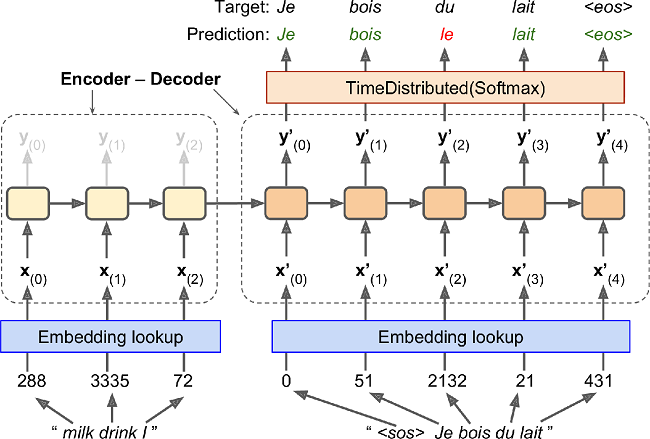
</p>


At each step, the **decoder outputs a score for each word in the output vocabulary** (i.e., French), and then the **softmax layer** turns these scores into **probabilities.** For example, at the first step the word “Je” may have a probability of 20%, “Tu” may have a probability of 1%, and so on. The word with the highest probability is output. **This is very much like a regular classification task,** so you can train the model using the "sparse_categorical_crossentropy" loss

Note that **at inference time** (after training), you will not have the target sentence to feed to the decoder. Instead, **simply feed the decoder the word that it output at the previous step,** (this will require an embedding lookup that is not shown in the diagram)

**Feeding the previous output word as input at inference time**

<p align='center'>
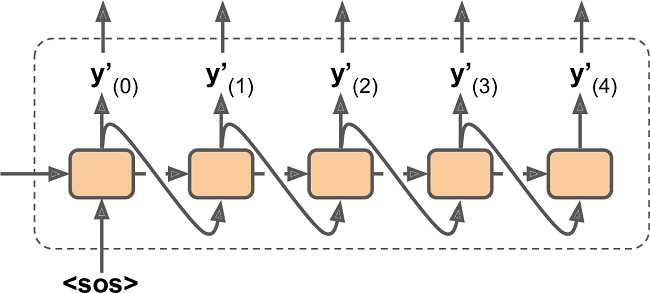
</p>


### Example: German to English Translation using seq2seq

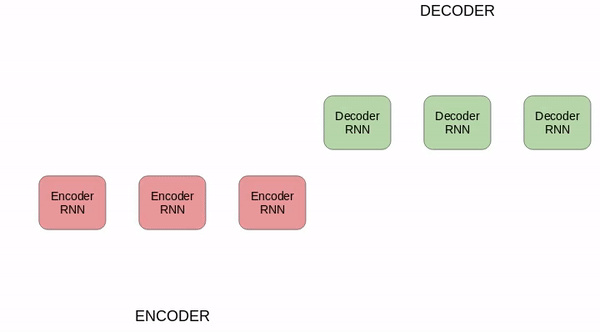

***The above seq2seq model is converting a German phrase to its English counterpart.***

* Both **Encoder** and **Decoder** are RNNs
* At every time step in the Encoder, the RNN takes a word vector (xi) from the input sequence and a hidden state (Hi) from the previous time step
* The hidden state is updated at each time step
* The hidden state from the last unit is known as the **context vector**. This contains information about the input sequence
* This context vector is then passed to the decoder and it is then used to generate the target sequence (English phrase)
* If we use the **Attention mechanism**, then the weighted sum of the hidden states are passed as the context vector to the decoder

In [65]:
tf.random.set_seed(42)

In [66]:
vocab_size = 100
embed_size = 10

In [67]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

***Notes***

* set return_state=True when creating the LSTM layer so that we can get its final hidden
state and pass it to the decoder. Since we are using an LSTM cell, it actually returns
two hidden states (short term and long term).

* The TrainingSampler is one of several
samplers available in TensorFlow Addons: their role is to tell the decoder at each step
what it should pretend the previous output was. During training, it should be the
embedding of the previous target token: this is why we used the TrainingSampler

* In
practice, it is often a good idea to start training with the embedding of the target of
the previous time step and gradually transition to using the embedding of the actual
token that was output at the previous step.

* This idea was introduced in a [2015 paper by Samy Bengio et al](https://homl.info/scheduledsampling)

In [68]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [69]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2
32/32 [==============================] - 6s 6ms/sample - loss: 4.6053
Epoch 2/2
32/32 [==============================] - 3s 3ms/sample - loss: 4.6031


### Bidirectional Recurrent Layers

***Some thoughts to make it better***

* a regular recurrent layer **only looks at past and present inputs**
before generating its output.

* This type of RNN makes sense when **forecasting time series**

* Neural Machine Translation is often **preferable to look ahead at
the next words** before encoding a given word

***The ideas***

* To implement this, **run two
recurrent layers** on the same inputs, one reading the words from left to right and the
other reading them from right to left. 

* Then simply **combine their outputs** at each
time step, typically by concatenating them

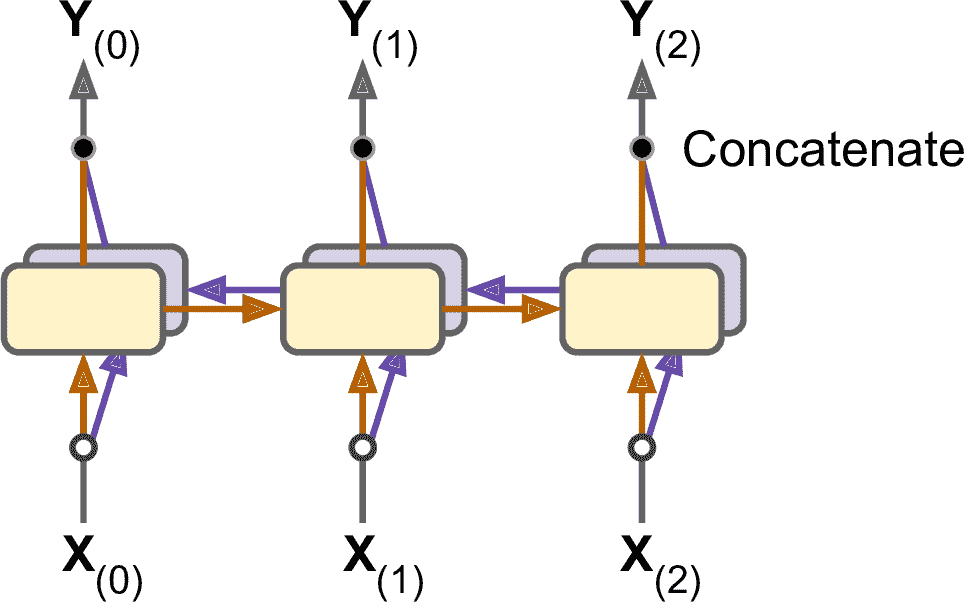

* To implement a bidirectional recurrent layer in Keras, wrap a recurrent layer in a
keras.layers.Bidirectional layer

In [70]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


***Notes***

* The Bidirectional layer will create a **clone of the GRU layer (but in
the reverse direction)**
* It will run both and **concatenate their
outputs**
* The GRU layer has 10 units, the Bidirectional
layer will output 20 values per time step.

### Introduction to Attention Mechanisms

***Thoughts***


* The path from the word “milk” to its translation “lait”is **too long**.
* Can we make the model better?
* How to **make the decoder more focused**? For example, at the time step
where the decoder needs to output the word “lait,” it will **focus its attention** on the
word “milk.”

***The theory***

* Allow the decoder to **focus on the appropriate words** (as encoded by the encoder) at each time step
* We want the path from an input word to its translation to be shorter, so the **short-term memory limitations of RNNs have much less impact**.

* It should have a significant **improvement for long sentences** (over 30 words)


***Neural machine translation using an Encoder–Decoder network with an
attention model***




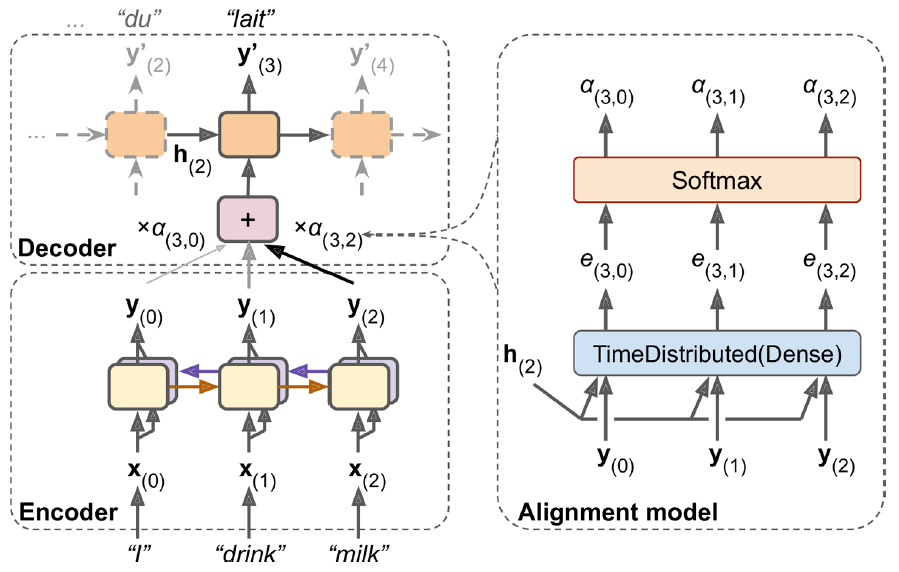

***Notes***

* Instead of just sending the encoder’s **final
hidden state** to the decoder (which is still done, although it is not shown in the figure),
we now send **all of its outputs** to the decoder
* At each time step, the decoder’s
memory cell computes a weighted sum of all these encoder outputs: this **determines
which words it will focus on at this step.**

* The
rest of the decoder works just like earlier: at each time step the memory cell receives **the inputs we just discussed, plus the hidden state from the previous time step, and
finally (although it is not represented in the diagram) it receives the target word from
the previous time step**


***Alignment Model or attention layer***: One of several atttention mechanisms. 

* small neural network to generate the weights

* it is trained jointly with the rest of the Encoder–Decoder model

* It starts with a time-distributed Dense layer15 with a single neuron, which receives as input all the encoder outputs, concatenated with the decoder’s previous hidden state

* This layer outputs a score (or energy) for each encoder output. This score measures how well each output is aligned with the decoder’s previous hidden state

* Finally, all the scores go through a softmax layer to get a final weight for each encoder
output

***Example***


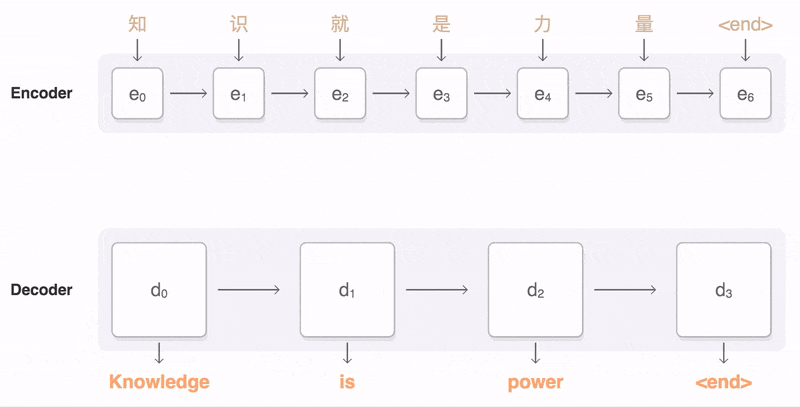